# Script to plot niches over the H&E images

In [1]:
import SimpleITK as sitk
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from skimage.transform import rescale, resize
from PIL import Image
import tifffile
import time
import tqdm
from pathlib import Path
import os
import math
from sklearn.metrics import adjusted_rand_score
plt.rc('legend', fontsize = 'large')
plt.rc('legend', markerscale = 3)

In [2]:
# Read in anndata with core labels assigned
adata = sc.read_h5ad('/common/lamt2/HPV/data/xenium/adata/adata_leiden_qc_latent_17_layers_4.h5ad')

In [3]:
# Dictionary to get the h&e file names from the xenium slide name
anno_dict = {
    '20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651': 'ag_hpv_01',
    '20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060077__Region_1__20250213__202651': 'ag_hpv_02',
    '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922': 'ag_hpv_04',
    '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060367__Region_1__20250224__233922': 'ag_hpv_03',
    '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0059911__Region_1__20250304__005817': 'ag_hpv_06',
    '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0060395__Region_1__20250304__005817': 'ag_hpv_05',
    '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060364__Region_1__20250305__223715': 'ag_hpv_08',
    '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060366__Region_1__20250305__223715': 'ag_hpv_07',
    '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060488__Region_1__20250312__004017': 'ag_hpv_09',
    '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060493__Region_1__20250312__004017': 'ag_hpv_10'
}

In [4]:
# Read in the cropping index dataframes
core_idx_df = pd.read_csv('/common/lamt2/HPV/data/xenium/alignment_v2/cropped_cores.csv', index_col = 0)
slide_idx_df = pd.read_csv('/common/lamt2/HPV/data/xenium/alignment_v2/cropped_slides.csv', index_col = 0)

# Xenium scale factor (pixel size to um)
sfs = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2
}

# Level for the full slide image tiff file
LEVEL = 5
sf = sfs[LEVEL]

# Output directory for images
dir_out = '/common/lamt2/HPV/figs/celltype/niches_miso_full/'

In [ ]:
# Make output directories (if does not exist)
for slide in list(anno_dict.values()):
    path = f'{dir_out}/{slide}'
    if not os.path.isdir(path):
        Path(path).mkdir(parents = True, exist_ok = True)

In [6]:
# Read in dataframe of celltypes
celltypes = pd.read_pickle('/common/lamt2/HPV/data/xenium/adata/celltypes_primary_v1_secondary_v3.pkl')

In [ ]:
# List for niche labels
niches = []

# Directories of niche labels
dirs = [
    'miso/data/outputs/scvi_agg_uniform_r88_virchow_weighted',
    #'miso/data/outputs/slide0_agg_virchow_autocluster',
    #'miso/data/outputs/slide0_scvi_virchow_autocluster',
    #'miso/data/outputs/slide0_scvi_agg_autocluster',
    #'miso/data/outputs/slide0_scvi_agg_virchow_weighted',
    #'miso/data/outputs/slide0_agg_virchow_weighted',
    #'miso/data/outputs/slide0_scvi_virchow_weighted',
    #'miso/data/outputs/slide0_agg_autocluster',
    #'miso/data/outputs/slide0_scvi_autocluster',
    #'miso/data/outputs/slide0_virchow_autocluster',
]

# Read in niches
for d in dirs:
    niches.append(pd.read_pickle(f'/common/lamt2/miso_rapids/{d}/niches.pkl'))

# Labels for each niche
labels = [
    'Miso: scvi + spatial(uniform r=88) + foundation model (weighted)',
    #'spatial + foundation model',
    #'scvi + foundation model',
    #'scvi + spatial(uniform r=88)',
    #'scvi + spatial(uniform r=88) + foundation model (weighted)',
    #'spatial + foundation model (weighted)',
    #'scvi + foundation model (weighted)',
    #'spatial (uniform r=88)',
    #'scvi',
    #'foundation model',
]

In [ ]:
# Put cellcharter niches at the beginning
niches.insert(0,pd.read_pickle('/common/lamt2/HPV/data/xenium/adata/niche_primary_v1_latent_17_layers_4.pkl'))
labels.insert(0,'Cellcharter')

In [9]:
# Only compare cells that have been niched in all methods
for niche in niches:
    adata = adata[adata.obs.index.isin(niche.index)]

In [10]:
# Transfer labels to the anndata
adata.obs['primary_celltype'] = celltypes['primary_celltype']
for i, niche in enumerate(niches):
    adata.obs[f'niche_{i}'] = niche

/tmp/ipykernel_2987569/4004990209.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['primary_celltype'] = celltypes['primary_celltype']


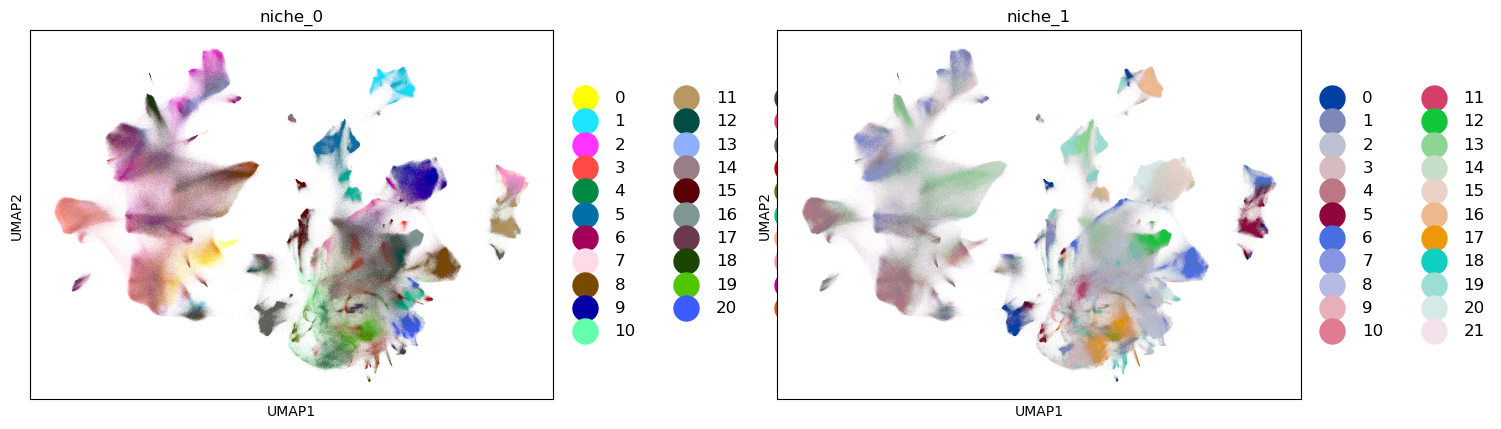

In [11]:
# Get the colors for niches by plotting the umap (probably a better way to do this)
sc.pl.umap(adata, color = [f'niche_{i}' for i in range(len(niches))], wspace = 0.3)

In [ ]:
# Labeling change for celltypes
adata.obs['primary_celltype'].replace('Stromal_NOS', 'NOS', inplace = True)

/tmp/ipykernel_2987569/1284748715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['primary_celltype'].replace('Stromal_NOS', 'NOS', inplace = True)
/tmp/ipykernel_2987569/1284748715.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['primary_celltype'].replace('Stromal_NOS', 'NOS', inplace =

Slide 20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651


Plotting core 10:   0%|          | 0/44 [00:00<?, ?it/s]                                                   

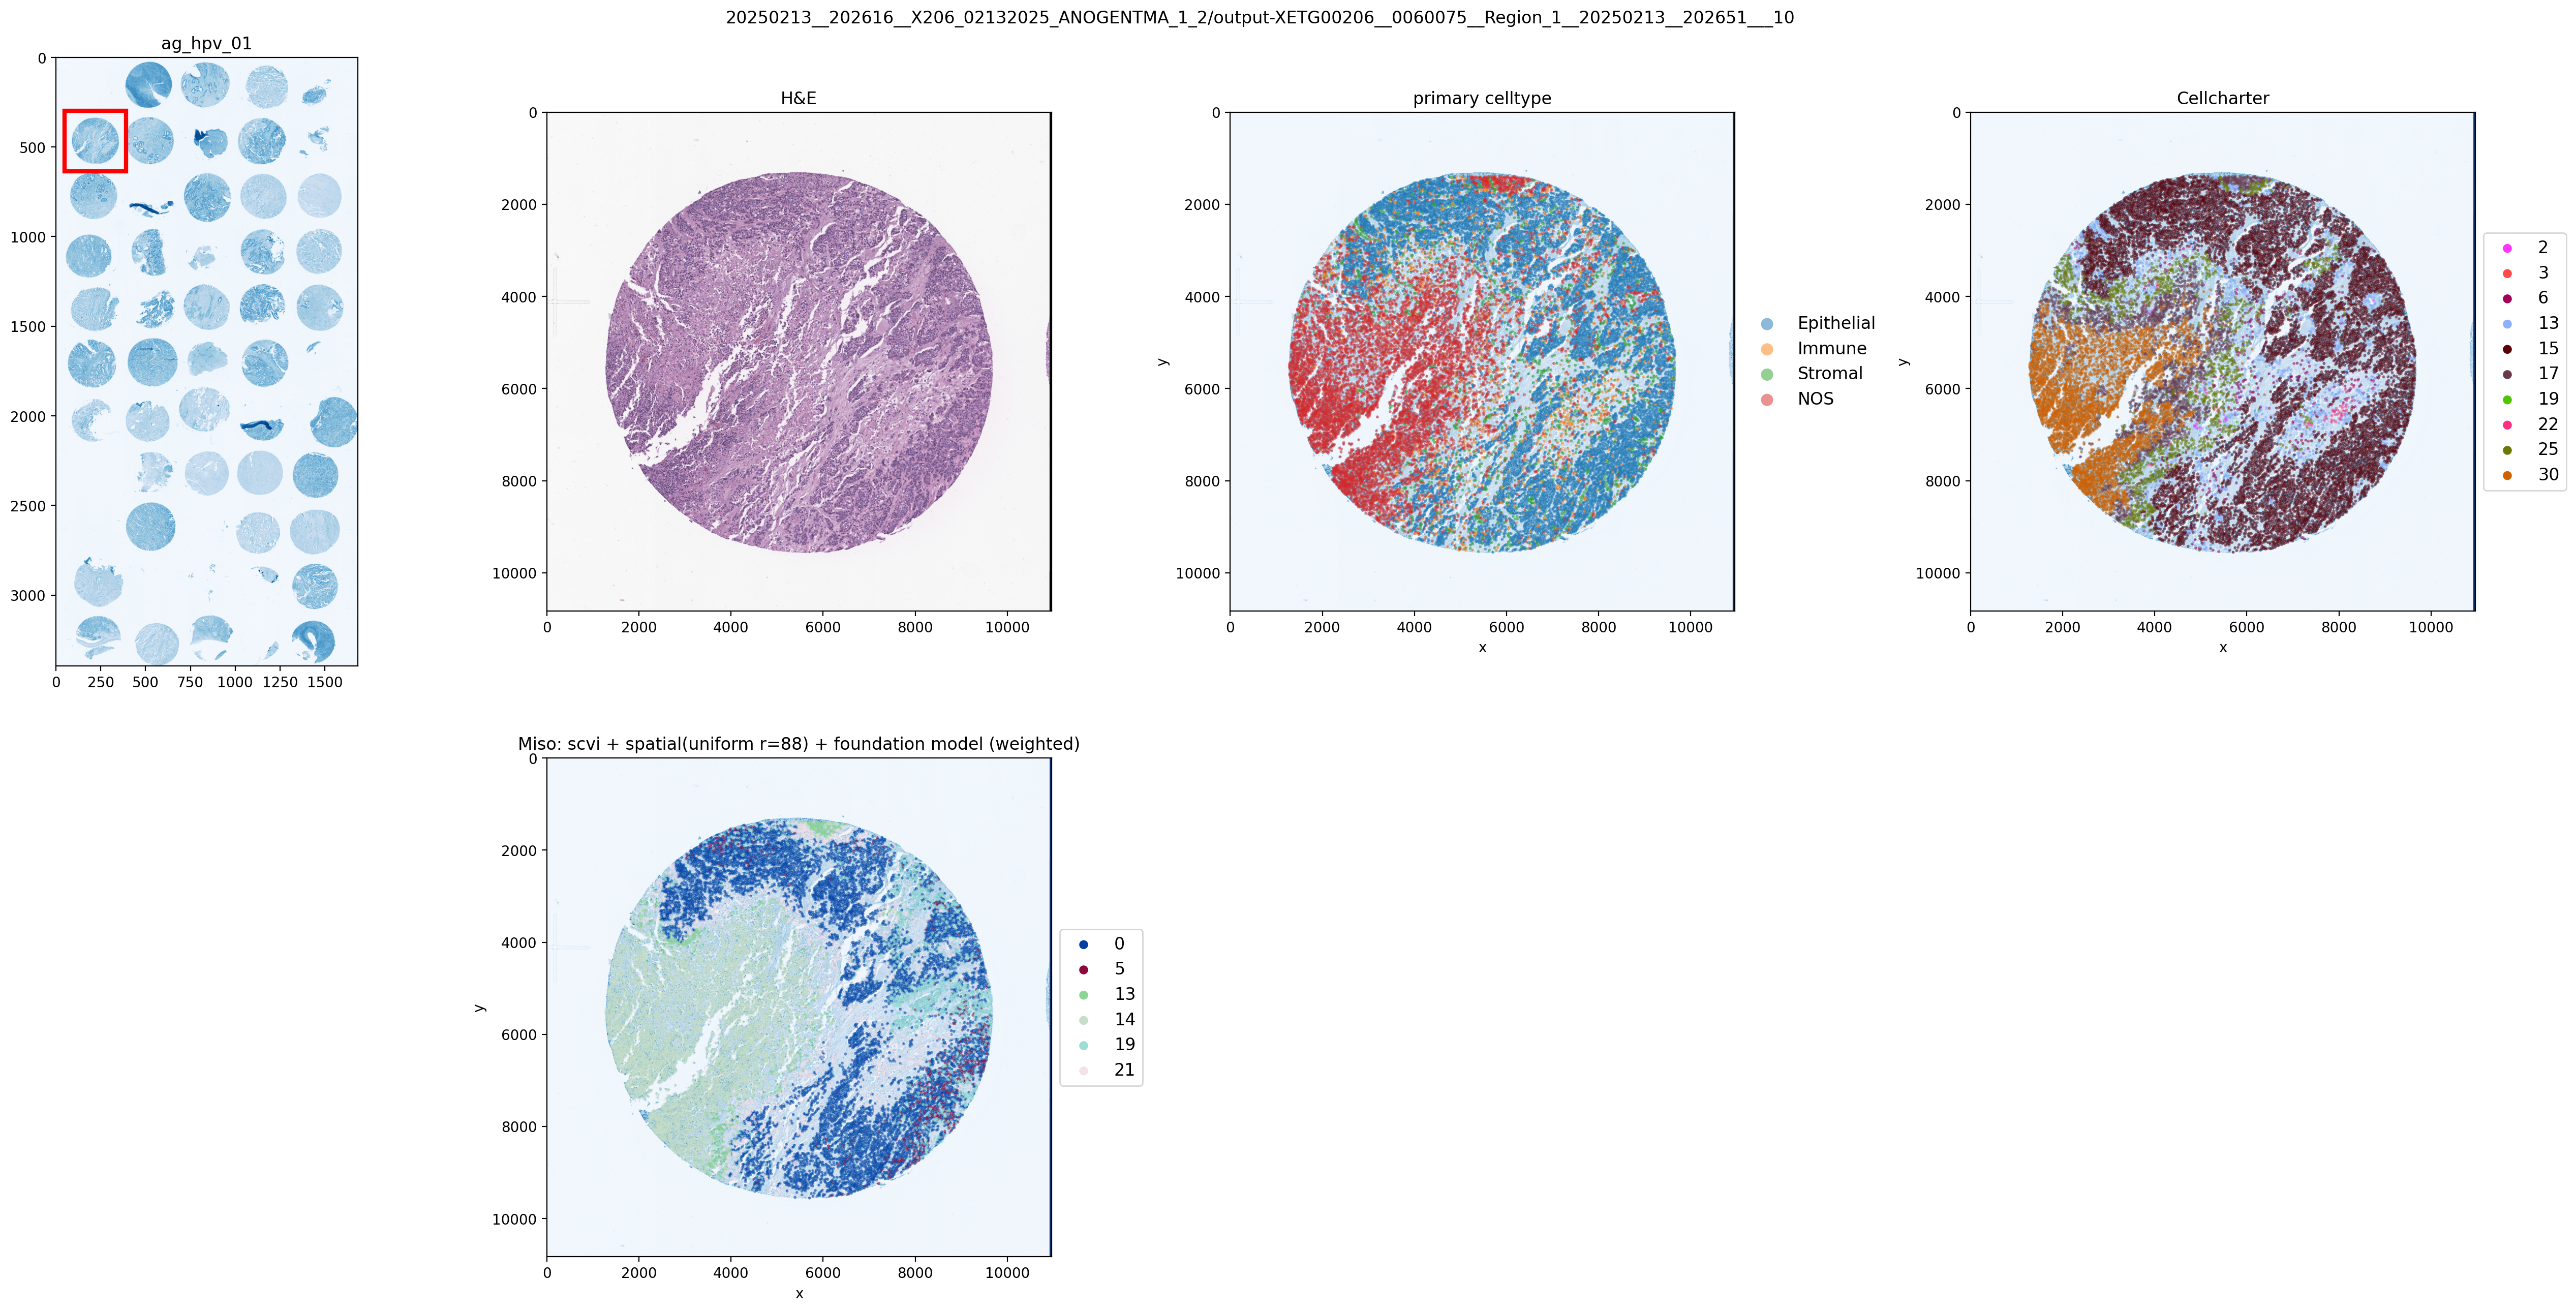

Plotting core 53: 100%|██████████| 44/44 [49:18<00:00, 67.24s/it]  

done: 49.40 min


In [ ]:
# Now for the plotting

# Outer loop over each slide
for slide in adata.obs['slide'].unique()[2:3]:
    t0 = time.time()
    print(f"Slide {slide}")
    # Read in the slide
    f_tiff = f'/common/knottsilab/xenium/hpv/svs/{anno_dict[slide]}.tiff'
    image_he = tifffile.imread(f_tiff, is_ome = False, level = LEVEL)
    
    # Rotate and invert the image
    arrm_r = np.rot90(image_he)
    arrm_r = arrm_r.max() - arrm_r

    # Get the full slide cropping coordinates and crop
    slide_idx = slide_idx_df.loc[slide]
    
    arrm_rc = arrm_r[arrm_r.shape[0] - int(slide_idx.x1*(2**(5-LEVEL))):arrm_r.shape[0] - int(slide_idx.x0*(2**(5-LEVEL))), int(slide_idx.y0*(2**(5-LEVEL))):int(slide_idx.y1*(2**(5-LEVEL)))]
    
    # Rescaling to match the coarse, full slide alignment procedure
    arrm_rc = rescale(arrm_rc.astype('float32'), 1.2, anti_aliasing=False)[:,:,0]

    arrm_rc *= (255.0/arrm_rc.max())
    arrm_rc = 255-arrm_rc
    
    # Convert from array back to image for alignment
    image_he= sitk.GetImageFromArray(arrm_rc.astype('float32'))

    # Read DAPI image
    f_fix = f'/common/knottsilab/xenium/hpv/{slide}/morphology_focus/morphology_focus_0000.ome.tif'
    arr_dapi = tifffile.imread(f_fix, is_ome = False, level = LEVEL)
    image_dapi = sitk.GetImageFromArray(arr_dapi.astype('float32'))
    
    # Read in the transformation and scale based on level
    modelnm = f'/common/lamt2/HPV/data/xenium/alignment_v2/aligned_slides/tfm_{slide.split('/')[-1]}.hdf'
    outTx_ogto0 = sitk.ReadTransform(modelnm)
    outTx_ogto0.SetTranslation(tuple(x *(2**(5-LEVEL+1)) for x in outTx_ogto0.GetTranslation())) 
    outTx_ogto0.SetCenter(tuple(x * (2**(5-LEVEL+1)) for x in outTx_ogto0.GetCenter())) 

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image_dapi)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(outTx_ogto0)

    # Apply slide alignment and get the array back from the image
    aligned_he = resampler.Execute(image_he)
    arr_slide = sitk.GetArrayFromImage(aligned_he)

    # Now we loop over each core on the current slide
    for i, core in enumerate(pbar:=tqdm.tqdm((adata[adata.obs['slide'] == slide].obs['core_idx'].unique()), desc = f'Plotting core {slide.split('/')[-1]}')):

        t1 = time.time()
        pbar.set_description(f'Plotting core {core}')
        # Skip core 0, these are background (shouldn't be there but maybe one or two slipped through because of sloppy coding)
        if core == 0:
            continue

        # Get the core cropping indices (used to offset cell x/y values)
        batch = f'{slide}___{core}'
        core_idx = core_idx_df.loc[batch]

        # Read in the aligned core image
        arr_core = np.load(f'/common/lamt2/HPV/data/xenium/alignment_v2/aligned_cores/{batch.split('/')[-1]}.npy')

        try:
            core_he_full = Image.open(f'/common/knottsilab/xenium/hpv/aligned_cores/{anno_dict[slide]}/{anno_dict[slide]}___{core}.png')
            core_he_full = core_he_full.resize((arr_core.shape[1], arr_core.shape[0]))
        except FileNotFoundError:
            print(f'Slide {anno_dict[slide]} core {core} does not have a full h&e image. Skipping')
            continue

        # Make two subplots: Left for full slide and right for individual core
        nrows = math.ceil((2+len(niches)) / 3)
        ncols = 4
        fig, ax = plt.subplots(nrows, ncols, figsize = (ncols*6.444, nrows * 6.444), dpi = 200, constrained_layout = True)
        
        fig.suptitle(f'{batch}')
        
        #  Plot the full h&e image
        ax[0][0].imshow(arr_slide, cmap = "Blues_r")
        # Draw a box around the core
        rect = patches.Rectangle((core_idx.x0 * (2**(4-LEVEL)), core_idx.y0 * (2**(4-LEVEL))), (core_idx.x1 - core_idx.x0) * (2**(4-LEVEL)), (core_idx.y1 - core_idx.y0) * (2**(4-LEVEL)), linewidth=3, edgecolor='r', facecolor='none')
        ax[0][0].add_patch(rect)
        ax[0][0].set_title(anno_dict[slide])
        
        # Plot full h&e image
        ax[0][1].imshow(core_he_full)
        ax[0][1].set_title("H&E")
        
        # Plot h&e core image as base layer below cells
        ax[0][2].imshow(arr_core[:,:,1], cmap = 'Blues_r')
        ax[0][2].set_title(f'Core {core_idx.core} - Primary celltypes')
        

        for n in range(len(niches)):
            row = (n+2) // (ncols-1)
            col = 1 + (n+2)%(ncols-1)
            ax[row][col].imshow(arr_core[:,:,1], cmap = "Blues_r")
            ax[row][col].set_title(f'Core {core_idx.core} - {labels[n]}')

        ad_core = adata[(adata.obs['slide'] == slide) & (adata.obs['core_idx'] == core_idx.core)].copy()
        xs_core = ad_core.obs['x_centroid']/sfs[0] - core_idx.x0 * (2**4)
        ys_core = ad_core.obs['y_centroid']/sfs[0] - core_idx.y0 * (2**4)
        ad_core.obs['x'] = xs_core
        ad_core.obs['y'] = ys_core
        
        # Get number of cells in core (for dot sizes)
        ncells = len(adata[(adata.obs['slide'] == slide) & (adata.obs['core_idx'] == core_idx.core)])
        s = 120000/ncells * 3.0
        
        # Primary celltypes
        sc.pl.scatter(
            ad_core,
            'x',
            'y',
            color = 'primary_celltype',
            alpha = 0.5,
            size = s,
            ax = ax[0][2],
            show = False,
        )

        for n, niche in enumerate(niches):
            row = (n+2) // (ncols-1)
            col = 1+(n+2)%(ncols-1)
            sc.pl.scatter(
                ad_core,
                x = 'x',
                y = 'y',
                color = f'niche_{n}',
                alpha = 0.5,
                size = s,
                ax = ax[row][col],
                show = False,
                title = labels[n]
            )
        
        # Delete extra subplots
        # Remove empty column below full h&e slide
        for row in range(1, nrows):
            ax[row][0].remove()
            
        # Remove extra axes at the end
        nimg_bottom_row = (2 + len(niches)) - (nrows-1) * (ncols - 1)
        for n in range(nimg_bottom_row+1, ncols):
            ax[nrows - 1][n].remove()
            
        legends = {}
        # Plot labeling stuff
        for n in range(len(niches)):
            row = (n+2) // (ncols-1)
            col = 1 + (n+2)%(ncols-1)
            ax[row][col].set_aspect('equal', adjustable = 'box')
            legends[n] = ax[row][col].legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
            for handle in legends[n].legend_handles:
                handle.set_alpha(1.0)

        # Save the plot
        plt.savefig(f'{dir_out}/{anno_dict[slide]}/{anno_dict[slide]}__{core_idx.core}.png', bbox_inches = 'tight', dpi = 300)
        if i%50 == 0: # Plot every 50 just to see what they look like
            plt.show()
        plt.close()
    print(f'done: {(time.time() - t0)/60:.2f} min')

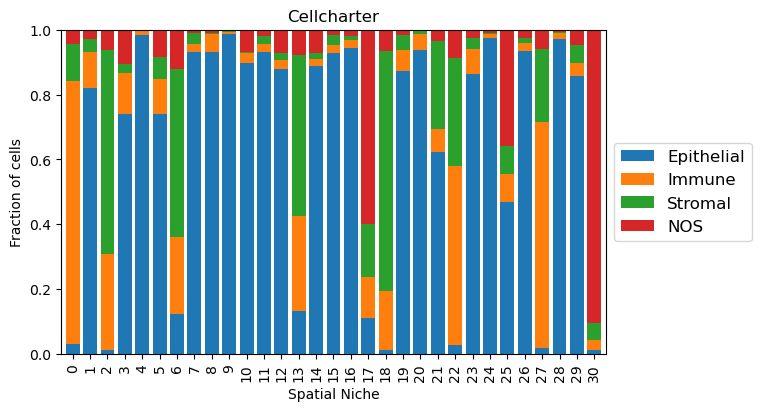

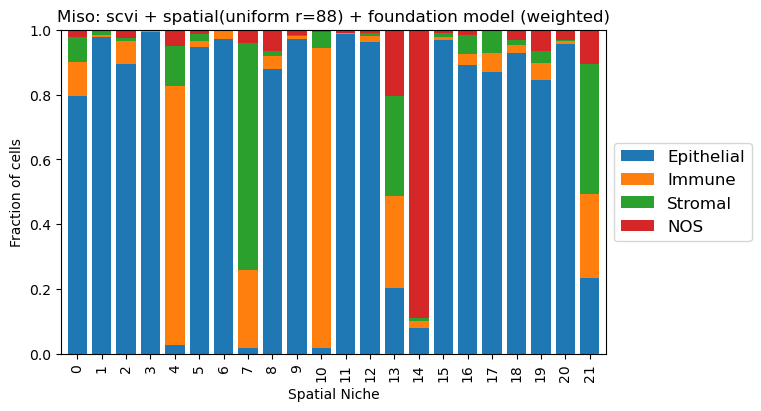

In [ ]:
# Plot the celltype composition of each niche
for i, niche in enumerate(niches):
    counts = adata.obs.groupby([f'niche_{i}', 'primary_celltype'], observed = True).size()
    counts = counts / adata.obs.groupby([f'niche_{i}'], observed = True).size()
    fig, ax = plt.subplots(1, 1, figsize = (15/2, 8/2), constrained_layout = True)
    counts.unstack().plot.bar(stacked = True, width = .8, ax = ax)
    ax.set_ylabel("Fraction of cells")
    ax.set_xlabel("Spatial Niche")
    ax.set_title(labels[i])
    ax.set_ylim(0, 1.0)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))